# Overview
This is the notebook for the classification problem presented - predicting the music genre of songs given the dataset provide from the Spotify API. The dataset includes $\approx 50,000$ samples of data randomly fetched from Spotify.

## Supervised Learning
Given we have the labels, we can approach this problem through a supervised learning technique. 

## Unsupervised Learning
However, given our dataset has missing values, we may need to approach handling the missing data with unsupervised learning techniques. Something that comes to mind before any code is written is PCA for linear dimensionality reduction and autoencoders for unsupervised network models.

In [1]:
import random
random.seed(14173755)

In [2]:
# import root path to use models and preprocessing-pipeline
import sys
sys.path.append(".")

# we'll import our necessary dependancies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch import optim

# import our pipeline modules and models
from data_pipeline import SongData

In [3]:
# let's get the data
data = pd.read_csv('./musicData.csv')
df = pd.DataFrame(data = data)

df.head(n = 10)

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.792000,A#,0.1150,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.950000,D,0.1240,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.011800,G#,0.5340,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.002530,C#,0.1570,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.909000,F#,0.1570,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic
5,89064.0,Axel Boman,Hello,47.0,0.00523,0.755,519468.0,0.731,0.854000,D,0.2160,-10.517,Minor,0.0412,?,4-Apr,0.614,Electronic
6,43760.0,Jordan Comolli,Clash,46.0,0.02890,0.572,214408.0,0.803,0.000008,B,0.1060,-4.294,Major,0.3510,149.995,4-Apr,0.230,Electronic
7,30738.0,Hraach,Delirio,43.0,0.02970,0.809,416132.0,0.706,0.903000,G,0.0635,-9.339,Minor,0.0484,120.008,4-Apr,0.761,Electronic
8,84950.0,Kayzo,NEVER ALONE,39.0,0.00299,0.509,292800.0,0.921,0.000276,F,0.1780,-3.175,Minor,0.2680,149.94799999999998,4-Apr,0.273,Electronic
9,56950.0,Shlump,Lazer Beam,22.0,0.00934,0.578,204800.0,0.731,0.011200,A,0.1110,-7.091,Minor,0.1730,139.933,4-Apr,0.203,Electronic


Now that we have our data in a dataframe, we can look at a very small sample of it so that way we can in what ways we should manipluate the data.

In [4]:
X = df.drop(columns = 'music_genre')
y = df['music_genre']

X.head(n = 10)

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.792000,A#,0.1150,-5.201,Minor,0.0748,100.889,4-Apr,0.759
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.950000,D,0.1240,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.011800,G#,0.5340,-4.617,Major,0.0345,127.994,4-Apr,0.333
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.002530,C#,0.1570,-4.498,Major,0.2390,128.014,4-Apr,0.270
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.909000,F#,0.1570,-6.266,Major,0.0413,145.036,4-Apr,0.323
5,89064.0,Axel Boman,Hello,47.0,0.00523,0.755,519468.0,0.731,0.854000,D,0.2160,-10.517,Minor,0.0412,?,4-Apr,0.614
6,43760.0,Jordan Comolli,Clash,46.0,0.02890,0.572,214408.0,0.803,0.000008,B,0.1060,-4.294,Major,0.3510,149.995,4-Apr,0.230
7,30738.0,Hraach,Delirio,43.0,0.02970,0.809,416132.0,0.706,0.903000,G,0.0635,-9.339,Minor,0.0484,120.008,4-Apr,0.761
8,84950.0,Kayzo,NEVER ALONE,39.0,0.00299,0.509,292800.0,0.921,0.000276,F,0.1780,-3.175,Minor,0.2680,149.94799999999998,4-Apr,0.273
9,56950.0,Shlump,Lazer Beam,22.0,0.00934,0.578,204800.0,0.731,0.011200,A,0.1110,-7.091,Minor,0.1730,139.933,4-Apr,0.203


In [5]:
y.head(n = 10)

0    Electronic
1    Electronic
2    Electronic
3    Electronic
4    Electronic
5    Electronic
6    Electronic
7    Electronic
8    Electronic
9    Electronic
Name: music_genre, dtype: object

In [6]:
# let's get the number music genres that are in the dataset
# let's test our class now
song_data = SongData(X, y)

labels, numLabels, label_count = song_data.labelExtraction(y)

print(f'Number of Labels: {numLabels}')
print()
print(f'Labels:')
for i in range(len(labels)):
    print(f'Label {i + 1}: {labels[i]}')
print()
print(f'Count of Labels: {label_count}')

/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The default value of numeric_only in DataFrame.min is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return reduction(axis=axis, out=out, **passkwargs)
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis

Number of Labels: 11

Labels:
Label 1: Rock
Label 2: Blues
Label 3: Electronic
Label 4: Jazz
Label 5: Alternative
Label 6: nan
Label 7: Rap
Label 8: Classical
Label 9: Hip-Hop
Label 10: Anime
Label 11: Country

Count of Labels: {'Rock': 5000, 'Blues': 5000, 'Electronic': 5000, 'Jazz': 5000, 'Alternative': 5000, nan: 5, 'Rap': 5000, 'Classical': 5000, 'Hip-Hop': 5000, 'Anime': 5000, 'Country': 5000}


/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [7]:
# now, let's check which features have missing data. insight will be helpful for data imputation
isMissing = df.isnull()
print(isMissing.sum())

instance_id         5
artist_name         5
track_name          5
popularity          5
acousticness        5
danceability        5
duration_ms         5
energy              5
instrumentalness    5
key                 5
liveness            5
loudness            5
mode                5
speechiness         5
tempo               5
obtained_date       5
valence             5
music_genre         5
dtype: int64


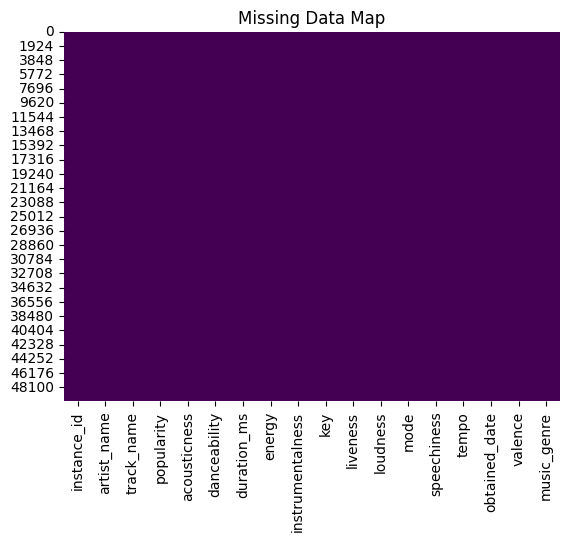

In [8]:
# now, plot a heatmap of the missing data
sns.heatmap(isMissing, cbar=False, cmap="viridis")
plt.title("Missing Data Map")
plt.show()